# Project: Investigating the European Soccer Match Database - The Winning Teams 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#References">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

The European Soccer Match database (**soccer_db.sqlite**) contains 25979 European league soccer match data from the 2008/2009 to 2015/2016 seasons as well as player and team attributes. The database consists of 7 tables:
- Country
- League
- Match
- Player
- Player_Attributes
- Team
- Team_Attributes
- sqlite_sequence

I am interested in investing this database to figure out the following questions:
- Which top 3 teams have won (not including draws) the most matches in its respective league?  
- Which teams have won the most matches in one season?
- What are the common team attributes in these top  teams?
- Who are the top goalkeepers?
- What are the common player attributes in these top goalkeepers? How do these attributes change against players' ages?

In [325]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import sqlite3
% matplotlib inline 
import sqlite3

In [326]:
# Connecting to the database file
con = sqlite3.connect("soccer_db.sqlite")
cur = con.cursor()
# The database file consists of 8 tables. Reading these tables into DF for further analysis
country_df = pd.read_sql_query("SELECT * from Country", con)
league_df = pd.read_sql_query("SELECT * from League", con)
match_df = pd.read_sql_query("SELECT * from Match", con)
player_df = pd.read_sql_query("SELECT * from Player", con)
player_attributes_df = pd.read_sql_query("SELECT * from Player_Attributes", con)
team_df = pd.read_sql_query("SELECT * from Team", con)
team_attributes_df = pd.read_sql_query("SELECT * from Team_Attributes", con)
sqlite_sequence_df = pd.read_sql_query("SELECT * from sqlite_sequence", con)

<a id='wrangling'></a>
## Data Wrangling


### General Properties

**x_df.head()** is used to understand the data structure and the first few rows of each df. 
In summary,
* country_df consists of 11 country id and country names.
* league_df consists of the league ids, respective country ids, and league names.
* match_df consists of detailed information about the 25979 matchs from 2008/2009 to 2015/2016, the home/away status of each team, players from each team, and other information such as goals, shoton, foulcommit, cards, etc. *This is an important table and the head rows are displayed*.
* player_df consists of player names, ids, birthdays, height, and weight.
* player_attributes_df consists of detailed FIFA game information on each player such as overall rating for each match, preferred foot, attack/defensive work rate, scores for key skills such as crossing, finishing, heading, short passing, dribbling, agility, shot power, goal keeper skills like diving, reflexes, etc. *The top rows of this table is displayed below.*
* team_df consists of team long names and short names.
* team_attributes_df consists of EA Sports' FIFA game scores and categorization of each team's qualities from 2010 to 2015. Example qualities include team speed, dribbling, passing, positioning, defence pressure, etc.. *Selected team Barcelona (team API ID 8634) is displayed below for illustration.*
* sqlite_sequence is not relevant for this data analysis.

**x_df.info()** is used to investigate missing data in each table. Most tables consist fairly complete data. No furhter data cleaning needs to be performed at this point.  

In [279]:
#match_df.head()

In [280]:
#player_attributes_df.head()

In [281]:
#team_attributes_df.query('team_api_id==8634')

<a id='eda'></a>
## Exploratory Data Analysis


### Top Three Winning Teams in Each League

In [253]:
# This script is used to identify the top three winning teams in each league.
# A new table that computes the winning match counts of each team needs to built from 
# the match table 
# The new table team_match_stat_df consists of each team's WINNING match counts at home and away, 
# as well as the goals at home and away games
# The data frrame is fairly complete for next step of analysis

In [327]:
df = pd.read_sql_query(
    """SELECT t.*,l.name AS league, hw_match_count, hw_goal,aw_match_count, aw_goal 
    FROM (
        SELECT * FROM Team) t INNER JOIN (
         SELECT league_id, home_team_api_id, COUNT(match_api_id) AS hw_match_count, SUM(home_team_goal) AS hw_goal
             FROM Match WHERE home_team_goal > away_team_goal GROUP BY 1, 2) hw 
        ON t.team_api_id = hw.home_team_api_id
        INNER JOIN (SELECT away_team_api_id, COUNT(match_api_id) AS aw_match_count, SUM(away_team_goal) AS aw_goal
             FROM Match WHERE home_team_goal < away_team_goal GROUP BY 1) aw 
             ON t.team_api_id = aw.away_team_api_id 
             AND hw.home_team_api_id = aw.away_team_api_id
        INNER JOIN (SELECT * FROM League) l ON l.country_id = hw.league_id
   """,con)
#df.info()
#df.hist(["hw_match_count","hw_goal","aw_match_count","aw_goal"])
#df

In [328]:
# Create dataframe sum_df that combines home & away match counts, and goals from home and away games 
sum_df = df.drop(['hw_match_count','hw_goal','aw_match_count','aw_goal'],axis=1).copy()
tot_match_count = df['hw_match_count'] + df['aw_match_count']
tot_goal = df['hw_goal'] + df['aw_goal']
sum_df['tot_match_count'] = tot_match_count
sum_df['tot_goal'] = tot_goal
#sum_df.sort_values(['team_long_name'])

In [329]:
# Find the top three winning teams within each league
grouped = sum_df.sort_values(by=['tot_match_count'],ascending=False).groupby('league')
t3t_df = grouped.head(3).sort_values(by=['league','tot_match_count'],ascending=False)
t3t_df

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,league,tot_match_count,tot_goal
290,49118,9931,896.0,FC Basel,BAS,Switzerland Super League,180,506
295,49117,10192,900.0,BSC Young Boys,YB,Switzerland Super League,142,401
297,49124,10243,894.0,FC Zürich,ZUR,Switzerland Super League,120,316
267,43042,8634,241.0,FC Barcelona,BAR,Spain LIGA BBVA,234,779
266,43040,8633,243.0,Real Madrid CF,REA,Spain LIGA BBVA,228,776
276,43053,9906,240.0,Atlético Madrid,AMA,Spain LIGA BBVA,167,423
246,39395,9925,78.0,Celtic,CEL,Scotland Premier League,218,613
247,39390,9927,83.0,Motherwell,MOT,Scotland Premier League,122,276
239,39393,8485,77.0,Aberdeen,ABE,Scotland Premier League,120,245
220,35294,9772,234.0,SL Benfica,BEN,Portugal Liga ZON Sagres,185,509



The table above illustrates the top three teams in these 11 leagues in the past 8 years. For example, the top three teams in Spain LIGA BBVA are FC Barcelona (won 234 matches with 779 goals!), Atletico Madrid, and Real Marid; the top three teams in Italy Serie A are Juventus(won 189 matches with 443 goals!), Roma, and AC Milan. **These 33 teams are considered the top winning teams for further analysis.**

### Which teams have won the most matches in one season?

In [330]:
season_df = pd.read_sql_query(
    """SELECT t.*,l.name AS league, hw.season as season, hw_match_count, hw_goal,aw_match_count, aw_goal 
    FROM (
        SELECT * FROM Team) t INNER JOIN (
         SELECT league_id, season, home_team_api_id, COUNT(match_api_id) AS hw_match_count, SUM(home_team_goal) AS hw_goal
             FROM Match WHERE home_team_goal > away_team_goal GROUP BY 1, 2, 3) hw 
        ON t.team_api_id = hw.home_team_api_id
        INNER JOIN (SELECT season, away_team_api_id, COUNT(match_api_id) AS aw_match_count, SUM(away_team_goal) AS aw_goal
             FROM Match WHERE home_team_goal < away_team_goal GROUP BY 1, 2) aw 
             ON t.team_api_id = aw.away_team_api_id 
             AND hw.home_team_api_id = aw.away_team_api_id
             AND hw.season = aw.season
        INNER JOIN (SELECT * FROM League) l ON l.country_id = hw.league_id
   """,con)

#season_df.head()
sum_season_df = season_df.drop(['hw_match_count','hw_goal','aw_match_count','aw_goal'],axis=1).copy()
season_tot_match_count = season_df['hw_match_count'] + season_df['aw_match_count']
season_tot_goal = season_df['hw_goal'] + season_df['aw_goal']
sum_season_df['tot_match_count'] = season_tot_match_count
sum_season_df['tot_goal'] = season_tot_goal
sum_season_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,league,season,tot_match_count,tot_goal
0,15,4049,NaN,Tubize,TUB,Belgium Jupiler League,2008/2009,7,15
1,9,7947,NaN,FCV Dender EH,DEN,Belgium Jupiler League,2008/2009,9,19
2,11,8203,110724.0,KV Mechelen,MEC,Belgium Jupiler League,2008/2009,12,28
3,12,8342,231.0,Club Brugge KV,CLB,Belgium Jupiler League,2008/2009,18,47
4,14,8571,100081.0,KV Kortrijk,KOR,Belgium Jupiler League,2008/2009,9,16


In [331]:
# Find the top winning teams in one season
t1t = sum_season_df.sort_values(by=['tot_match_count'],ascending=False)
#match_df[(match_df.league_id == 10257) & (match_df.season == '2013/2014') & ((match_df.home_team_api_id == 9885) | (match_df.away_team_api_id == 9885))].shape
t1t.head(1)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,league,season,tot_match_count,tot_goal
689,20522,9885,45.0,Juventus,JUV,Italy Serie A,2013/2014,33,74


**The top team was Juventus in 2013/2014 season, winning 33 matches of the 38 matches it played in this season. **

## Common attributes in these top  teams


t3t_attributres_df is created to describe the attributes of the top 33 teams, while nt3t_attributes_df is to describe the attributes of the other teams. All the attribute values are by season. 

In [332]:
t3t_id = t3t_df['team_api_id']
#Top 33 teams
t3t_attributes_df = team_attributes_df.loc[team_attributes_df['team_api_id'].isin(t3t_id)]
#t3t_attributes_df.describe()

In [333]:
#The other teams
nt3t_attributes_df = team_attributes_df.loc[~team_attributes_df['team_api_id'].isin(t3t_id)]
#nt3t_attributes_df.describe()

Plot the 9 attributes of the top 33 teams and the other teams to visualize the key differences in team attributes.

Text(0.5,1,'Histogram of Defence Team Width')

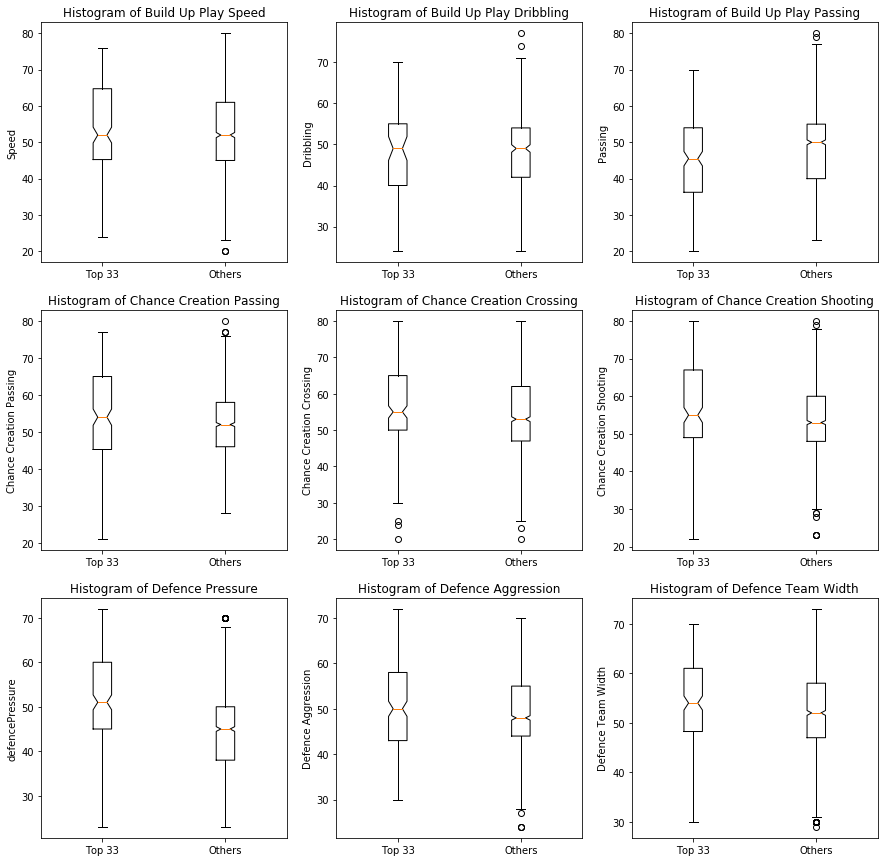

In [334]:
fig,axs = plt.subplots(3,3, figsize=(15,15))

#Build Up Play Speed
axs[0,0].boxplot([t3t_attributes_df['buildUpPlaySpeed'],nt3t_attributes_df['buildUpPlaySpeed']], 
                 notch=True, labels=['Top 33','Others'])
axs[0,0].set_title('Histogram of Build Up Play Speed')
axs[0,0].set_ylabel('Speed')

##Build Up Play Dribbling
axs[0,1].boxplot([t3t_attributes_df['buildUpPlayDribbling'].dropna(how='all'), nt3t_attributes_df['buildUpPlayDribbling'].dropna(how='all')], 
              notch=True, labels=['Top 33','Others'])
axs[0,1].set_ylabel('Dribbling')
axs[0,1].set_title('Histogram of Build Up Play Dribbling')

#Build Up Play Passing
axs[0,2].boxplot([t3t_attributes_df['buildUpPlayPassing'],
                nt3t_attributes_df['buildUpPlayPassing']],notch=True, labels=['Top 33','Others'])
axs[0,2].set_ylabel('Passing')
axs[0,2].set_title('Histogram of Build Up Play Passing')

#Chance Creation Passing
axs[1,0].boxplot([t3t_attributes_df['chanceCreationPassing'],
                nt3t_attributes_df['chanceCreationPassing']],notch=True, labels=['Top 33','Others'])
axs[1,0].set_ylabel('Chance Creation Passing')
axs[1,0].set_title('Histogram of Chance Creation Passing')

#Chance Creation Crossing
axs[1,1].boxplot([t3t_attributes_df['chanceCreationCrossing'],
                nt3t_attributes_df['chanceCreationCrossing']],notch=True, labels=['Top 33','Others'])
axs[1,1].set_ylabel('Chance Creation Crossing')
axs[1,1].set_title('Histogram of Chance Creation Crossing')

#Chance Creation Shooting
axs[1,2].boxplot([t3t_attributes_df['chanceCreationShooting'],
                nt3t_attributes_df['chanceCreationShooting']],notch=True, labels=['Top 33','Others'])
axs[1,2].set_ylabel('Chance Creation Shooting')
axs[1,2].set_title('Histogram of Chance Creation Shooting')

#Defence Pressure
axs[2,0].boxplot([t3t_attributes_df['defencePressure'],
                nt3t_attributes_df['defencePressure']],notch=True, labels=['Top 33','Others'])
axs[2,0].set_ylabel('defencePressure')
axs[2,0].set_title('Histogram of Defence Pressure')

#Defence Aggression
axs[2,1].boxplot([t3t_attributes_df['defenceAggression'],
                nt3t_attributes_df['defenceAggression']],notch=True, labels=['Top 33','Others'])
axs[2,1].set_ylabel('Defence Aggression')
axs[2,1].set_title('Histogram of Defence Aggression')

#Defence Team Width
axs[2,2].boxplot([t3t_attributes_df['defenceTeamWidth'],
                nt3t_attributes_df['defenceTeamWidth']],notch=True, labels=['Top 33','Others'])
axs[2,2].set_ylabel('Defence Team Width')
axs[2,2].set_title('Histogram of Defence Team Width')


From these 9 plots, we see that the top teams did not have significant advantages over other teams in build up play attributes like speed, dribbling and even did worse in passing; however, **top teams tend to have better performance in all the chance creation attributes including passing, crossing, and shooting, as well as defence attributes like pressure, aggression, and team width**. Therefore, teams that can navigate chances more effectively and have higher defence capabilities may be able to perform better in the European soccer leagues from 2008 to 2016. 

## Top goalkeepers

Defence capability seems to key to become top European soccer teams in the last 8 years. It would be interesting to deep-dive into goalkeepers. Since the databases do not specifiy players positions, there are no accurate way to identify goalkeepers. However, there are five goalkeeper attributes in the Player_Attribute table - gk_diving, gk_handling, gk_kicking, gk_positioning, and gk_reflexes. By quickly scrubbing through non-goalkeepers' attribute scores, most of their gk scores are less than 60. Therefore, I assume that if a player's **average gk attribute scores are above 60**, he is in the goalkeeper position. 

unique_goalkeeper_df is used to identify the unique goalkeepers and their peak goalkeeping attributes in the past 8 years. There are about 857 goalkeepers among the 11060 players (~7.75%) in the last 8 years.

In [335]:
unique_goalkeeper_df = pd.read_sql_query(
    """ SELECT distinct player_name, avg(avg_gk_score) AS avg_gk_score, avg(gk_diving) AS avg_gk_diving, 
    avg(gk_handling) AS avg_gk_handling, avg(gk_kicking) AS avg_gk_kicking, avg(gk_positioning) AS avg_gk_positioning,
     avg(gk_reflexes) AS avg_gk_reflexes FROM (
        SELECT distinct p.player_name, avg_gk_score, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes
        FROM player p INNER JOIN 
            (SELECT  pa.*,  (pa.gk_diving + pa.gk_handling + pa.gk_kicking + pa.gk_positioning 
        + pa.gk_reflexes)/5 AS avg_gk_score
        FROM player_attributes pa
        LEFT JOIN player ply ON pa.player_fifa_api_id = ply.player_fifa_api_id 
        WHERE avg_gk_score > 60
            ) gkp 
            ON p.player_fifa_api_id = gkp.player_fifa_api_id AND p.player_api_id = gkp.player_api_id
            ) gk_stat
    GROUP BY 1
   """,con)
#unique_goalkeeper_df.info()

As expected, Gianluigi Buffon, Iker Casillas, and Edwin van der Sar were among the best goalkeepers in the last 8 years.

In [336]:
unique_goalkeeper_df.sort_values(by='avg_gk_score', ascending = False).head(10)

,player_name,avg_gk_score,avg_gk_diving,avg_gk_handling,avg_gk_kicking,avg_gk_positioning,avg_gk_reflexes
217,Edwin van der Sar,85.166667,84.000000,87.000000,85.000000,91.333333,80.333333
488,Manuel Neuer,84.800000,87.266667,81.933333,86.600000,82.466667,87.000000
646,Petr Cech,83.785714,87.214286,83.428571,77.214286,85.500000,87.642857
692,"Robert Enke,30",83.400000,83.200000,84.600000,78.000000,86.000000,87.200000
326,Iker Casillas,83.000000,89.882353,82.235294,69.470588,84.823529,91.000000
819,Victor Valdes,82.769231,83.769231,77.307692,81.538462,84.846154,87.615385
640,Pepe Reina,82.687500,83.312500,78.750000,87.062500,82.437500,84.750000
283,Gianluigi Buffon,82.210526,87.684211,83.000000,68.421053,90.210526,84.315789
320,Hugo Lloris,81.588235,85.647059,81.470588,74.529412,81.294118,86.823529
362,Jens Lehmann,81.250000,79.250000,86.250000,75.500000,88.000000,79.000000


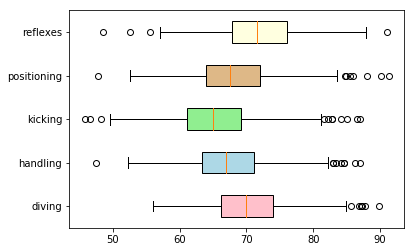

In [337]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
bplots = plt.boxplot([unique_goalkeeper_df['avg_gk_diving'],unique_goalkeeper_df['avg_gk_handling'],
             unique_goalkeeper_df['avg_gk_kicking'],unique_goalkeeper_df['avg_gk_positioning'],
             unique_goalkeeper_df['avg_gk_reflexes']], vert = False,
            patch_artist = True,
            labels = ['diving','handling','kicking','positioning','reflexes']
           )

# fill with colors
colors = ['pink','lightblue','lightgreen','burlywood', 'lightyellow']

for bplot in (bplots):
    for patch, color in zip(bplots['boxes'], colors):
        patch.set_facecolor(color)

Out of the five goalkeeper attributes, reflexes is the attribute that has the highest average score, followed by diving. The next analysis aims to understand how these attribute scores vary against goalkeepers' ages. 

## Goalkeeper attributes that change over ages

To analyze how each goalkeeping attribute change over a player's age, soa.df (skill over age) is constructed with the following fields:
- goalkeeper_player_age
- avg_gk_score, 
- avg_gk_diving,
- avg_gk_handling,
- avg_gk_kicking,
- avg_gk_positioning,
- avg_gk_reflees

In [338]:
# There are NaN values in the age column. They will be removed in the final df. 
soa_df = pd.read_sql_query(
    """ SELECT age, count(player_fifa_api_id) as cnt_player,avg(avg_gk_score) as avg_gk_score, avg(gk_diving) as avg_gk_diving, 
    avg(gk_handling) as avg_gk_handling, avg(gk_kicking) as avg_gk_kicking, avg(gk_positioning) as avg_gk_positioning,
    avg(gk_reflexes) as avg_gk_reflexes
    FROM (
        SELECT   pa.player_fifa_api_id, cast((pa.date - p.birthday) as float) as age,
        (pa.gk_diving + pa.gk_handling + pa.gk_kicking + pa.gk_positioning 
        + pa.gk_reflexes)/5 AS avg_gk_score, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes
        FROM player_attributes pa
        LEFT JOIN player p ON pa.player_fifa_api_id = p.player_fifa_api_id 
        AND pa.player_api_id = p.player_api_id
        WHERE avg_gk_score > 60
        AND age IS NOT Null
        ) a
    GROUP BY 1 ORDER BY 1 
   """,con,coerce_float=True)
#soa_df

There are goalkeepers started playing for leagues as young as eight!


Text(0,0.5,'Attribute Value')

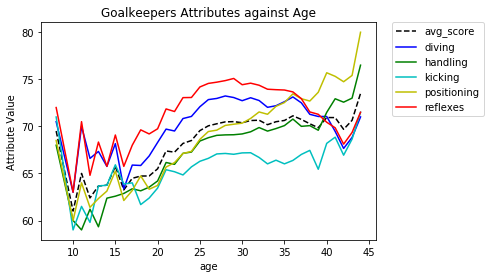

In [339]:
line1, = plt.plot(soa_df['age'], soa_df['avg_gk_score'], 'k--',label = 'avg_score')
line2, = plt.plot(soa_df['age'], soa_df['avg_gk_diving'], 'b-',label = 'diving')
line3, = plt.plot(soa_df['age'], soa_df['avg_gk_handling'], 'g-', label = 'handling')
line4, = plt.plot(soa_df['age'], soa_df['avg_gk_kicking'], 'c-',label = 'kicking')
line5, = plt.plot(soa_df['age'], soa_df['avg_gk_positioning'], 'y-',label = 'positioning')
line6, = plt.plot(soa_df['age'], soa_df['avg_gk_reflexes'], 'r-',label = 'reflexes')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title('Goalkeepers Attributes against Age')
plt.xlabel('age')
plt.ylabel('Attribute Value')

It seems that there are several outliers at relatively young ages (<12) and older ages (>=44). The following codes aim to remove these outliers.

Text(0,0.5,'Attribute Value')

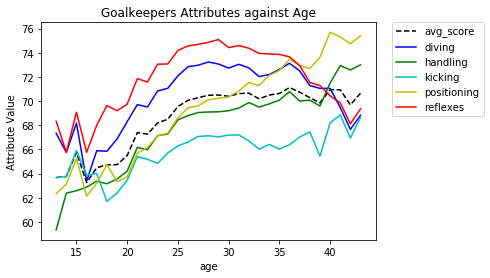

In [340]:
# There are NaN values in the age column. They will be removed in the final df.
soa_df = pd.read_sql_query(
    """ SELECT age, count(player_fifa_api_id) as cnt_player,avg(avg_gk_score) as avg_gk_score, avg(gk_diving) as avg_gk_diving, 
    avg(gk_handling) as avg_gk_handling, avg(gk_kicking) as avg_gk_kicking, avg(gk_positioning) as avg_gk_positioning,
    avg(gk_reflexes) as avg_gk_reflexes
    FROM (
        SELECT   pa.player_fifa_api_id, cast((pa.date - p.birthday) as float) as age,
        (pa.gk_diving + pa.gk_handling + pa.gk_kicking + pa.gk_positioning 
        + pa.gk_reflexes)/5 AS avg_gk_score, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes
        FROM player_attributes pa
        LEFT JOIN player p ON pa.player_fifa_api_id = p.player_fifa_api_id 
        AND pa.player_api_id = p.player_api_id
        WHERE avg_gk_score > 60
        AND age IS NOT Null
        AND age>12 AND age <44
        ) a
    GROUP BY 1 ORDER BY 1 
   """,con,coerce_float=True)
#soa_df
line1, = plt.plot(soa_df['age'], soa_df['avg_gk_score'], 'k--',label = 'avg_score')
line2, = plt.plot(soa_df['age'], soa_df['avg_gk_diving'], 'b-',label = 'diving')
line3, = plt.plot(soa_df['age'], soa_df['avg_gk_handling'], 'g-', label = 'handling')
line4, = plt.plot(soa_df['age'], soa_df['avg_gk_kicking'], 'c-',label = 'kicking')
line5, = plt.plot(soa_df['age'], soa_df['avg_gk_positioning'], 'y-',label = 'positioning')
line6, = plt.plot(soa_df['age'], soa_df['avg_gk_reflexes'], 'r-',label = 'reflexes')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title('Goalkeepers Attributes against Age')
plt.xlabel('age')
plt.ylabel('Attribute Value')

- On average goalkeepers' attribute scores peak between 25 and 29 then remain relatively flat. 
- Average attributes plateau out as goalkeepers age but reflexes and diving scores gradually decline, while positioning, handling and kicking skills improve.
- From soccer knowledge, "older" goalkeepers are more experienced in directing defence and even milfielders to form effective defence squad. This knowledge aligns with what we see in data -- experienced goalkeepers rely on handling, positioning, and kicking, more than reflexes and diving, which are both skills for rescuing, aka "last line of defense". 

<a id='References'></a>
## References


matplotlib style <https://stackoverflow.com/questions/14770735/changing-figure-size-with-subplots/14770827>

matplot color <https://matplotlib.org/gallery/statistics/boxplot_color.html>